In [2]:
%matplotlib inline
import seaborn as sns
import numpy as np

from brainiak.eventseg.event import EventSegment
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition

from scipy.spatial.distance import squareform, pdist
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [3]:
T = 100
F = 10
features = np.cumsum(np.random.randn(T, F), axis=0)

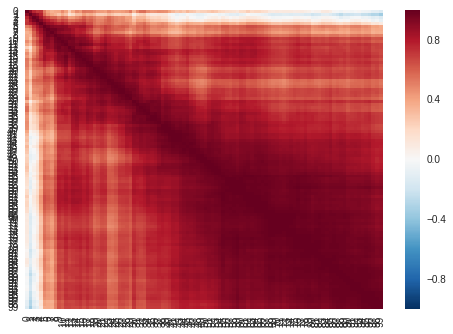

In [4]:
sns.heatmap(np.corrcoef(features))

In [5]:
def interpolate(data, n_samples, degree=10):
    '''
    given data (timepoints by features), return a new n_samples by features matrix
    of interpolated values
    '''
    x = np.arange(data.shape[0])
    xx = np.linspace(0, data.shape[0]-1, n_samples)
    
    def interp_helper(y):
        model = make_pipeline(PolynomialFeatures(degree), Ridge())
        model.fit(x[:, np.newaxis], y[:, np.newaxis])
        return np.squeeze(model.predict(xx[:, np.newaxis]))
    
    yy = np.zeros([n_samples, data.shape[1]])
    for i in np.arange(data.shape[1]):
        yy[:, i] = interp_helper(data[:, i])
    
    return yy

In [6]:
def segment(data, n):
    ev = EventSegment(n)
    ev.fit(data)
    bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]
    return [np.insert(bounds, [0, len(bounds)], [0, data.shape[0] - 1]), ev]

In [7]:
def rmdiag(m):
    return m - np.diag(np.diag(m))

def mat2vec(m):
    x = m.shape[0]
    v = np.zeros(int((x*x - x)/2 + x))
    v[0:x] = np.diag(m)

    #force m to be symmetric (sometimes rounding errors get introduced)
    m = np.triu(rmdiag(m))
    m += m.T

    v[x:] = squareform(rmdiag(m))
    return v


def vec2mat(v):
    x = int(np.round(0.5*(np.sqrt(8*len(v) + 1) - 1)))
    return squareform(v[x:]) + np.diag(v[0:x])


def r2z(r):
    return 0.5*(np.log(1+r) - np.log(1-r))


def z2r(z):
    return (np.exp(2*z) - 1)/(np.exp(2*z) + 1)

In [12]:
def repeatability_index(data):
    '''
    look for repeated structure:
    1.) for full data matrix (timepoints by features), use segment to get event bounds (number of events = n)
    2.) interpolate each "event" to give it the same number of features (stretch to longest event length)
    3.) use segment to get sub-event bounds within each event (number of sub-events = m)
    4.) compute a n-subevents by n-subevents correlation matrix for each event using values from 3
    5.) compute mean inter-event correlation between the squareform of the correlation matrices in 4.  this is the "repeatability" index given n and m
    6.) use a grid search to find the n and m that maximize the repeatability index (up to n = number of timepoints/2 and m = number of timepoints / (2 * n))
    '''
    if type(data) == list:
        data = np.array(data)        
    if np.ndim(data) == 1:
        data = data[:, np.newaxis]
        
    def index_helper(data, n, m):
        [event_bounds, event_model] = segment(data, n)
        max_event_size = np.max([np.max(np.diff(event_bounds)), m])
        events = np.zeros([max_event_size, data.shape[1], n])
        for i in np.arange(1, len(event_bounds)):
            events[:, :, i-1] = interpolate(data[event_bounds[i-1]:event_bounds[i], :], max_event_size)
        
        sub_event_dists = np.zeros([n, int((m**2 - m)/2)])
        for i in np.arange(n):
            next_event = np.squeeze(events[:, :, i])
            [sub_event_bounds, sub_event_model] = segment(next_event, m)
            sub_events = np.zeros([m, data.shape[1]])
            for j in np.arange(m):
                sub_events[j, :] = np.mean(next_event[sub_event_bounds[j]:sub_event_bounds[j+1], :], axis=0)
            sub_event_dists[i, :] = -pdist(sub_events)
            
        corr_sum = 0
        for i in np.arange(sub_event_dists.shape[0]):
            other_inds = list(np.arange(i))
            other_inds.extend(list(np.arange(i+1, sub_event_dists.shape[0])))
            others = np.mean(sub_event_dists[other_inds, :], axis=0)
            corr_sum += r2z(pearsonr(sub_event_dists[i, :], others)[0])
        return z2r(corr_sum / float(sub_event_dists.shape[0]))
    
    ix = -np.infty * np.ones([int(np.floor(data.shape[0]/2)), int(np.floor(data.shape[0]/2))])
    for n in np.arange(2, int(np.floor(data.shape[0]/2))):
        max_m = int(np.floor(data.shape[0] / (2*float(n))))
        for m in np.arange(2, max_m):
            ix[n, m] = index_helper(data, n, m)
    #return ix
    params = list(np.array(list(map(int, np.where(ix == np.nanmax(ix))))) + 2)
    return np.nanmax(ix), params[0], params[1]

In [13]:
features = np.cumsum(np.random.randn(10, 4), axis=0)
features = np.vstack((features, features))
features = np.vstack((features, features))

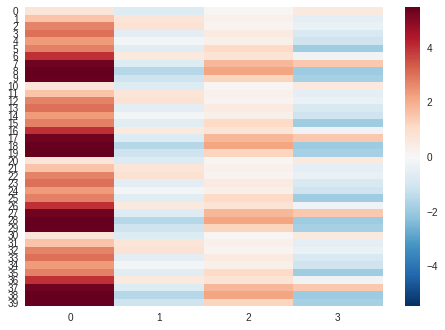

In [14]:
sns.heatmap(features)

In [15]:
ix, n, m = repeatability_index(features)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [16]:
[n, m]

NameError: name 'n' is not defined

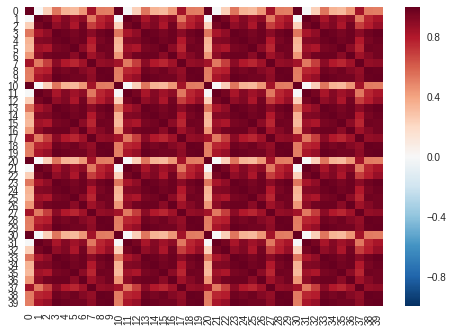

In [17]:
sns.heatmap(1 - squareform(pdist(features, 'correlation')))